In [1]:
import time

t0 = time.time()

***
# INTRODUCTION

The goal of this notebook was to create and adjust the model of recognizing the activity of a person based on a raw accelerometer data consisting of x,y and z measurements (representing motion along three orthogonal axes). The training dataset was included in two files - one file with raw accelerometer measurements with corresponding timestamps and a second file with labelled activities which were available for only 10% of raw measurements.

I decided to use three main models that were presented during the course (Logistic Regression, Random Fores, KNN Classifier) and one model out of scope (SVC). The plan was to train and test all models and then pick the one best performing.

Before model introduction, there are several steps of data cleaning, data visualization and imputing missing values since it was somehow obvious to me that I shall use more of the raw data (other than labelled in trains_labels.csv).

***
# 1. Data preprocessing
***

In [1]:
# Import
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
%pprint

import matplotlib.pyplot as plt
import seaborn as sns

Pretty printing has been turned OFF


In [2]:
# Reading training data (raw measurement and labels)
raw_data = pd.read_csv('train_time_series.csv', index_col=0)
train_labels = pd.read_csv('train_labels.csv', index_col=0)

# A quick look at the table
raw_data.head()

,timestamp,UTC time,accuracy,x,y,z
20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450


In [4]:
# First merge - all raw data with corresponding labels for future imputer calibration
full_file = pd.merge(raw_data, train_labels, on=['timestamp'], how='left')

# Droping unnecessary columns first merged file
full_file = full_file.drop(['UTC time_x','UTC time_y', 'accuracy'], axis=1)

# A quick look at full file and predictors numbers
display(full_file.info())
display(full_file.label.value_counts(dropna=False))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744 entries, 0 to 3743
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3744 non-null   int64  
 1   x          3744 non-null   float64
 2   y          3744 non-null   float64
 3   z          3744 non-null   float64
 4   label      375 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 175.5 KB


None

NaN    3369
2.0     213
3.0      88
4.0      47
1.0      27
Name: label, dtype: int64

In [5]:
# Raw data file clean-up by removing unnecessary columns - this dataframe will be used to build complete observations dataframe
data = raw_data.drop(['accuracy', 'UTC time'], axis=1)
data.set_index('timestamp')

# Checking for missing values
display(data.isna().any())

timestamp    False
x            False
y            False
z            False
dtype: bool

In [6]:
# Labels dataframe clean-up by removing unnecessary columns
train_labels = train_labels.drop(['UTC time'], axis=1)

# Checking for missing values
display(train_labels.isna().any())

timestamp    False
label        False
dtype: bool

In [7]:
# Merging dataframes of data and labels - creating complete observations file
working_data = pd.merge(data, train_labels, on=['timestamp'])
working_data.set_index('timestamp')

display(Counter(working_data.label))
display(working_data.head(10))
display(working_data.info())

Counter({2: 213, 3: 88, 4: 47, 1: 27})

,timestamp,x,y,z,label
0,1565109931087,-0.053802,-0.987701,0.068985,1
1,1565109932090,0.013718,-0.852371,-0.000870,1
2,1565109933092,0.145584,-1.007843,-0.036819,1
3,1565109934094,-0.099380,-1.209686,0.304489,1
4,1565109935097,0.082794,-1.001434,-0.025375,1
5,1565109936099,0.037582,-0.998383,0.019333,1
6,1565109937101,-0.020554,-0.999741,0.120789,1
7,1565109938103,0.032440,-0.970337,0.241425,1
8,1565109939106,0.212524,-0.976364,0.074997,1
9,1565109940108,0.154510,-0.843460,0.010544,2


<class 'pandas.core.frame.DataFrame'>
Int64Index: 375 entries, 0 to 374
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  375 non-null    int64  
 1   x          375 non-null    float64
 2   y          375 non-null    float64
 3   z          375 non-null    float64
 4   label      375 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 17.6 KB


None

***
### Now we have two dataframes for future work:

**working_data** - a dataframe with complete observations (375 rows)

**full_file** - a dataframe with all measurements and provided labels (3744 rows)

***
# 2. Vizualising values
***

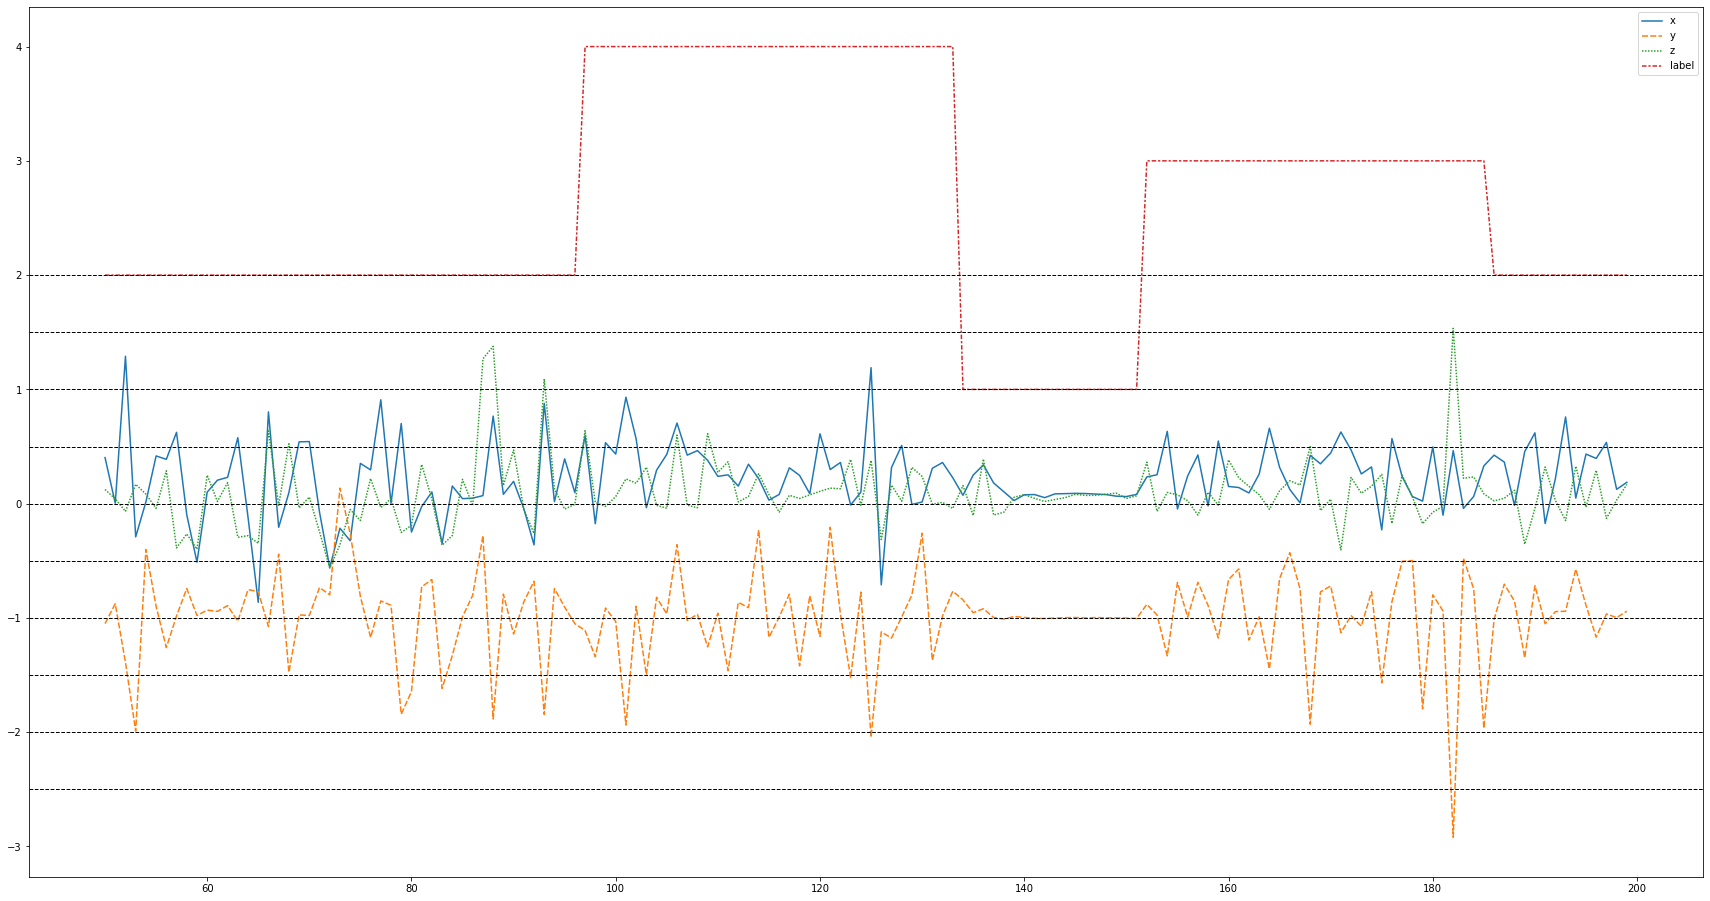

In [8]:
# A slice from complete observations dataframe
working_data_for_vision = working_data[['x','y','z','label']][50:200]
plt.figure(figsize=(30,16))
lines = sns.lineplot(data=working_data_for_vision)

# Drawing horizontal lines for a better visibility
steps = np.linspace(-2.5,2,10)
for s in steps:
    lines.axhline(s, ls='--', linewidth=1, color='black')

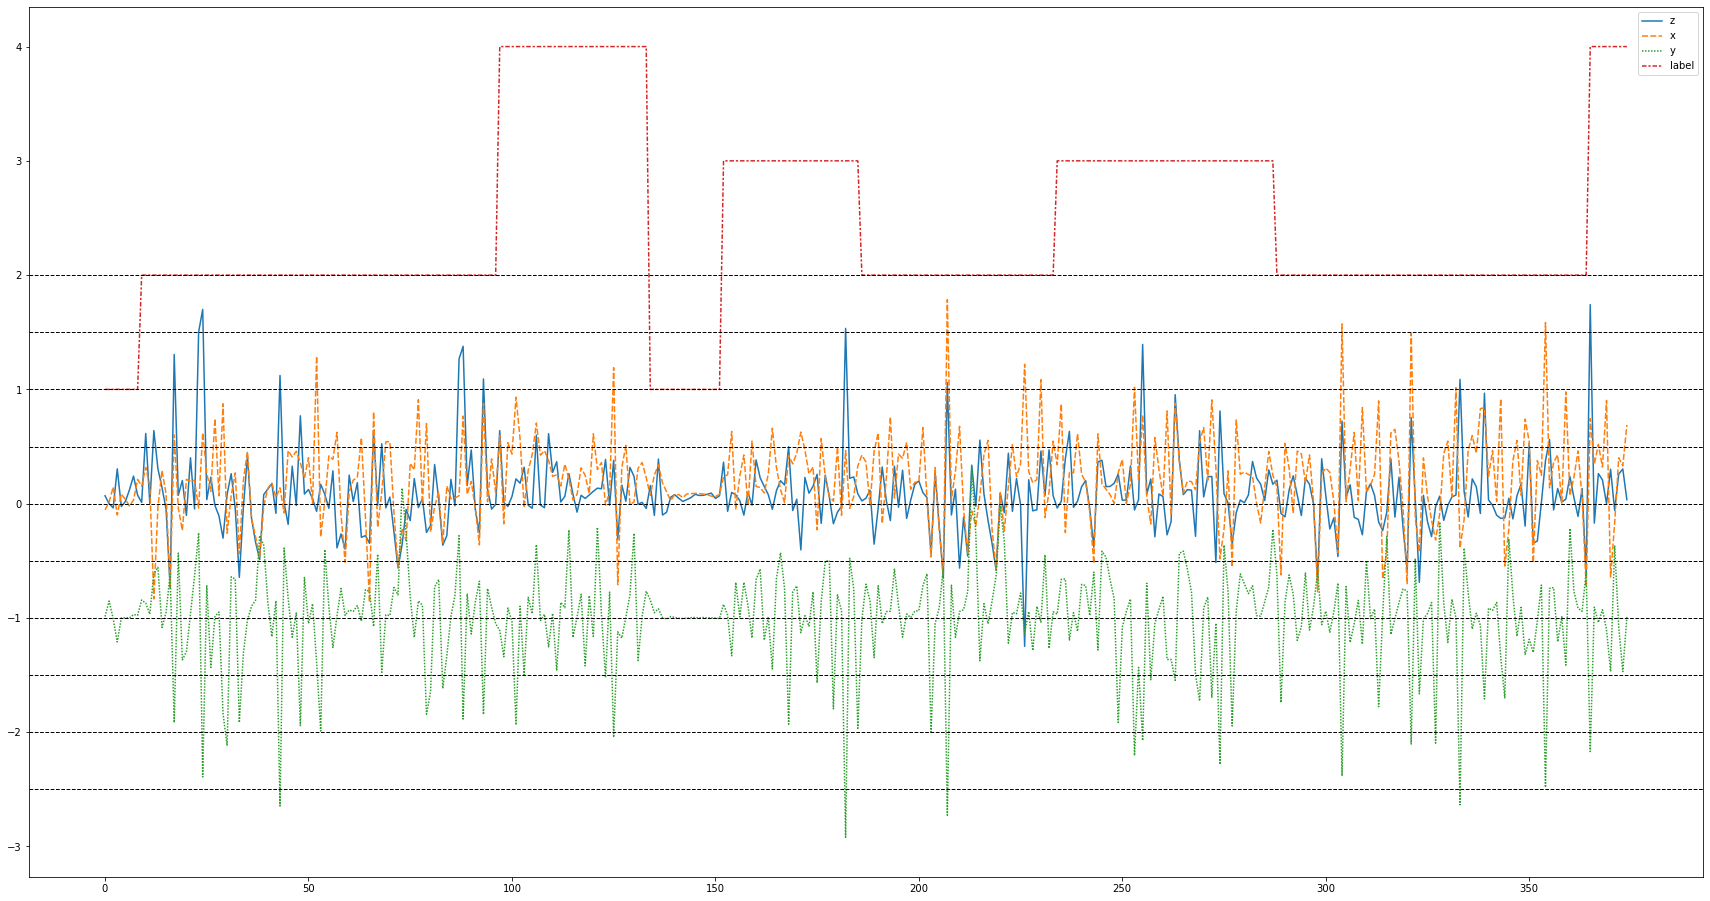

In [9]:
# A complete observations dataframe
working_data_for_vision = working_data[['z','x','y','label']]
plt.figure(figsize=(30,16))
lines = sns.lineplot(data=working_data_for_vision)
steps = np.linspace(-2.5,2,10)
for s in steps:
    lines.axhline(s, ls='--', linewidth=1, color='black')

***
### *This was the moment that I found some patterns obvious (like all the lines getting flat during activity labelled 1 - standing), but other labels were full of noise.*
###  *So below I decided to add some combinations of predictors to visualization dataframe and check if I can find anything useful.*
***

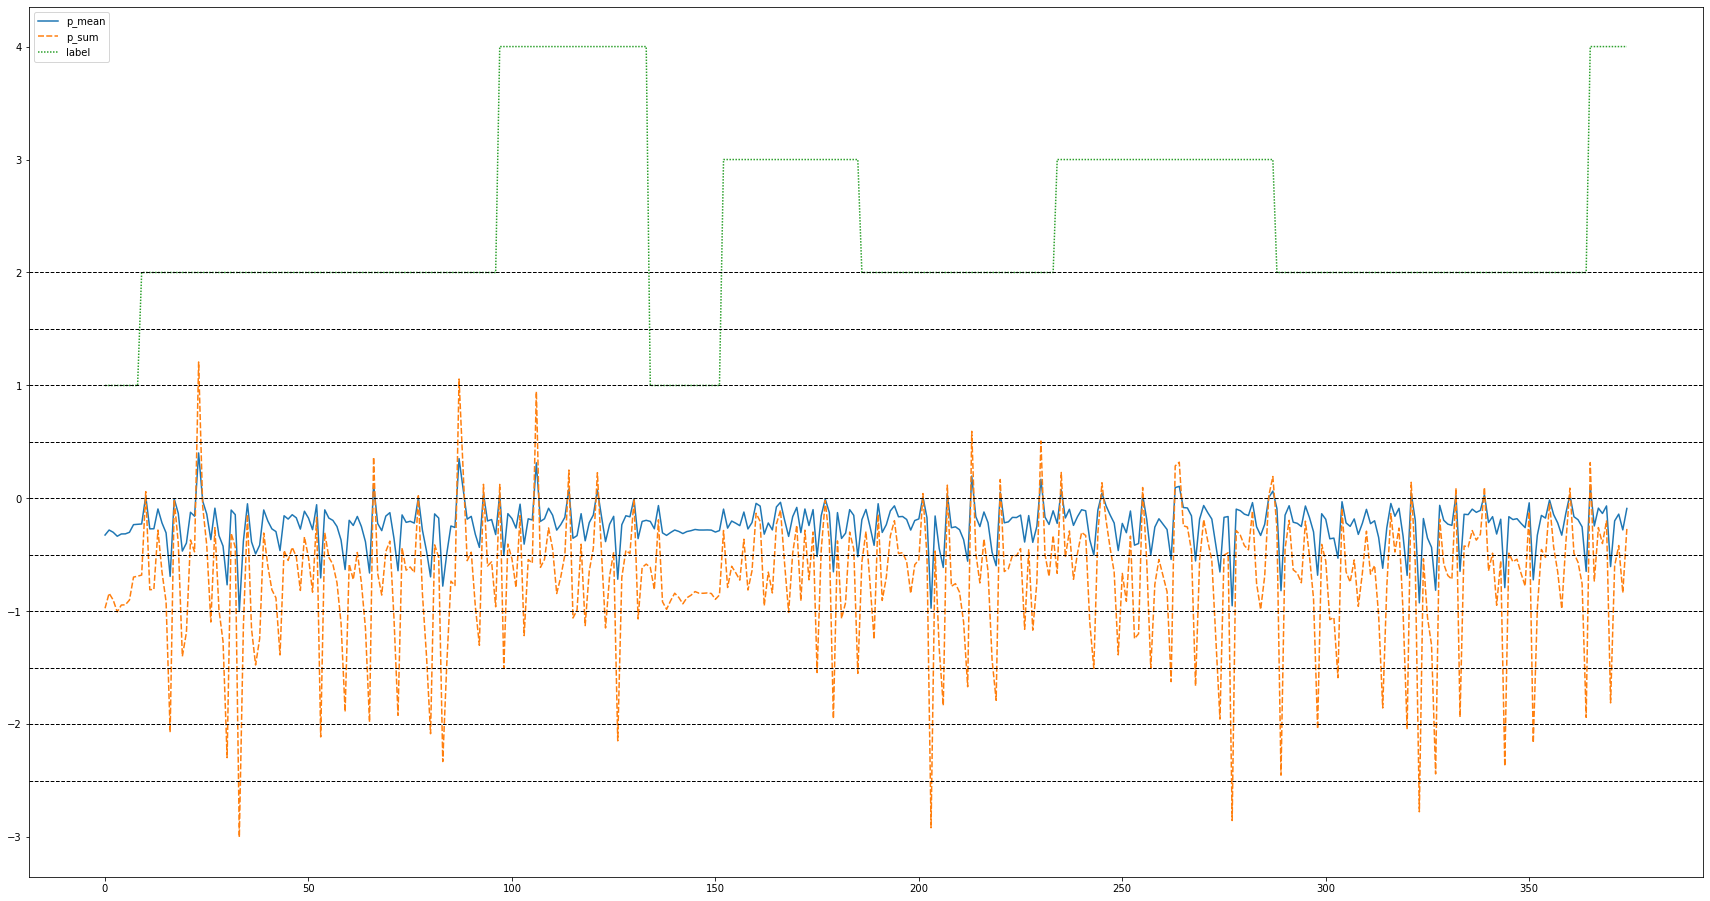

In [10]:
working_data_for_vision_ext = working_data[['z','x','y','label']]
sum_predictors = working_data_for_vision_ext.y + working_data_for_vision_ext.z + working_data_for_vision_ext.x
sum_mean = (working_data_for_vision_ext.y + working_data_for_vision_ext.z + working_data_for_vision_ext.x) / 3

# Adding predictors' sum
working_data_for_vision_ext['p_sum'] = sum_predictors

# Adding predictors' mean
working_data_for_vision_ext['p_mean'] = sum_mean

working_data_for_vision_ext = working_data_for_vision_ext[['p_mean', 'p_sum', 'label']]
plt.figure(figsize=(30,16))
lines = sns.lineplot(data=working_data_for_vision_ext)
steps = np.linspace(-2.5,2,10)
for s in steps:
    lines.axhline(s, ls='--', linewidth=1, color='black')

<AxesSubplot:>

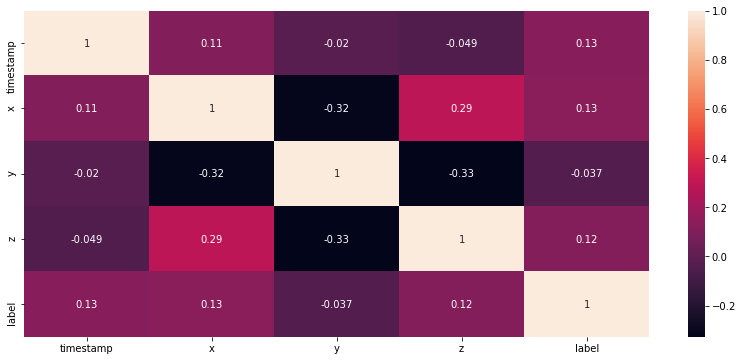

In [11]:
# Correlation matrix, not much info
corr_matrix = working_data.corr().round(5)
plt.figure(figsize = (14,6))
sns.heatmap(corr_matrix,annot = True)

***
### *Based on a lineplot, label 1 occurs when 'x' and 'z' remain close around the value of 0 and 'y' stays near -1 for some time (consecutive values)*
***

In [12]:
# I wrote a function to recognize the spots where subject was standing (flat spot on a plot)
def recognize_ones(df, neighbours=5):
    """
    For a given df, function recognizes consecutive occurrences of neighbours (both directions) of x,y,z in ranges and updates labels of all of them. 
    """
    min_max_xz = (-0.6, 0.5)
    min_max_y = (-1.25, -0.6)
    for r in range(0, len(df)-neighbours):
        if df.iloc[r:r+2*neighbours].x.between(*min_max_xz).all() and df.iloc[r:r+2*neighbours].z.between(*min_max_xz).all() and df.iloc[r:r+2*neighbours].y.between(*min_max_y).all():
            df.iloc[r:r+2*neighbours].label.fillna(1, inplace=True)

# Function invocation on full_file dataframe
recognize_ones(full_file,80)

In [13]:
# Checking the results of calling a function. Result: 158 more '1' labels
display(full_file.info())
display(full_file.label.value_counts(dropna=False))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744 entries, 0 to 3743
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3744 non-null   int64  
 1   x          3744 non-null   float64
 2   y          3744 non-null   float64
 3   z          3744 non-null   float64
 4   label      533 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 175.5 KB


None

NaN    3211
2.0     213
1.0     185
3.0      88
4.0      47
Name: label, dtype: int64

***
### *There a are number of conditions when 2 occurs, but one obvious one is when y > 0 and y < 2.92*
### *Finally, I decided not to update any '2's based on a plot.*
***

In [14]:
# Recognizing values: 2
# full_file.loc[full_file.y >= 0, 'label'] = 2
# full_file.loc[full_file.y <= -2.92, 'label'] = 2

In [15]:
# Extracting all full rows from full file for an imputer input.
full_file_for_imp_training = full_file.dropna()
full_file_for_imp_training.drop('timestamp', axis = 1, inplace=True)
full_file_for_imp_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 3 to 3743
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       533 non-null    float64
 1   y       533 non-null    float64
 2   z       533 non-null    float64
 3   label   533 non-null    float64
dtypes: float64(4)
memory usage: 20.8 KB


In [16]:
# I needed to check the performance of the imputer somehow. So I decided to exclude a sample from a complete observations dataframe, nullify that values in imputer input file 
# and than compare with real values.
sample_from_working_data = working_data.sample(37)
working_data.drop(index=sample_from_working_data.index, inplace=True)
working_data.drop('timestamp', axis = 1, inplace=True)
display(working_data.info())
display(sample_from_working_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 0 to 374
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       338 non-null    float64
 1   y       338 non-null    float64
 2   z       338 non-null    float64
 3   label   338 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 13.2 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 107 to 141
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  37 non-null     int64  
 1   x          37 non-null     float64
 2   y          37 non-null     float64
 3   z          37 non-null     float64
 4   label      37 non-null     int64  
dtypes: float64(3), int64(2)
memory usage: 1.7 KB


None

***
### Imputer Calibration
***

In [17]:
# KNN Imputer seemed most reasonable in my opinion
from sklearn.impute import KNNImputer

# Creating and fitting imputer
imputer = KNNImputer(n_neighbors=1, weights='uniform').fit(full_file_for_imp_training)

In [18]:
# Nullyfing labels from sample dataframe
full_file.label.loc[full_file.timestamp.isin(sample_from_working_data.timestamp)] = np.nan

# Dropping 'timestamp' column
full_file.drop('timestamp', axis = 1, inplace=True)
display(full_file.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744 entries, 0 to 3743
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       3744 non-null   float64
 1   y       3744 non-null   float64
 2   z       3744 non-null   float64
 3   label   496 non-null    float64
dtypes: float64(4)
memory usage: 146.2 KB


None

In [19]:
# Imputing values to the whole data dataframe
full_file = pd.DataFrame(imputer.transform(full_file), columns=full_file.columns)

# Rounding labels to whole numbers
full_file.label = full_file.label.round().astype(int)
display(full_file.info())
display(full_file.label.value_counts(dropna=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3744 entries, 0 to 3743
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       3744 non-null   float64
 1   y       3744 non-null   float64
 2   z       3744 non-null   float64
 3   label   3744 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 102.5 KB


None

2    1911
3     854
1     573
4     406
Name: label, dtype: int64

In [20]:
# Displaying labels from previously taken observation dataframe
print('TRUE DATA')
display(sample_from_working_data.label.value_counts())

# Displaying labels imputed by KNN imputer
print('IMPUTER')
full_file_to_compare = full_file[full_file.index.isin(sample_from_working_data.index)]
display(full_file_to_compare.label.value_counts())

# I run imputer calibration many times as sample is random. Once I got a decent score, I moved on.

TRUE DATA


2    20
3     9
4     6
1     2
Name: label, dtype: int64

IMPUTER


2    20
3     8
1     6
4     3
Name: label, dtype: int64

***
# 3. Creating and fitting a model

## Using random forest,  logistic regression, KNN classifier and SVC
***

In [21]:
# Selecting X, Y
X = full_file[['x', 'y', 'z']]
Y = full_file['label']

# Spliting data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (2995, 3)
Training Labels Shape: (2995,)
Testing Features Shape: (749, 3)
Testing Labels Shape: (749,)


In [22]:
# Fitting models with training data
classification_model = RandomForestClassifier(n_estimators = 50, random_state=1, max_depth=10, max_leaf_nodes=1000).fit(X_train, y_train)
logistic_model = LogisticRegression(random_state=1).fit(X_train, y_train)
knn_model = KNeighborsClassifier(n_neighbors=1, weights='uniform').fit(X_train, y_train)
svc_model = SVC().fit(X_train, y_train)

In [23]:
# Printing results
print('Correct Prediction (%) for Random Forests: ', accuracy_score(y_test, classification_model.predict(X_test), normalize = True) * 100.0)
print('Correct Prediction (%) for Logistic Regression: ', accuracy_score(y_test, logistic_model.predict(X_test), normalize = True) * 100.0)
print('Correct Prediction (%) for KNN Classifier: ', accuracy_score(y_test, knn_model.predict(X_test), normalize = True) * 100.0)
print('Correct Prediction (%) for SVC Classifier: ', accuracy_score(y_test, svc_model.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%) for Random Forests:  75.56742323097463
Correct Prediction (%) for Logistic Regression:  50.60080106809078
Correct Prediction (%) for KNN Classifier:  84.64619492656877
Correct Prediction (%) for SVC Classifier:  59.813084112149525


In [24]:
# Additional model check

from sklearn.model_selection import cross_val_score

cv = cross_val_score(classification_model, X_train, y_train, cv=10, scoring='accuracy')
print(f'CV accuracy for basic random forest: {cv.mean()}')

cv = cross_val_score(logistic_model,  X_train, y_train, cv=10, scoring='accuracy')
print(f'CV accuracy for basic logistic regression: {cv.mean()}')

cv = cross_val_score(knn_model,  X_train, y_train, cv=10, scoring='accuracy')
print(f'CV accuracy for basic knn: {cv.mean()}')

CV accuracy for basic random forest: 0.7235295429208473
CV accuracy for basic logistic regression: 0.49749721293199556
CV accuracy for basic knn: 0.8220256410256411


In [25]:
# Adjusting parameters of random forest. I run it several times with different x values for n_estimators, max_depth, max_leaf_nodes.
for x in [5, 50, 500, 5000]:
    model = RandomForestClassifier(n_estimators = 500, random_state=1, max_depth=50 , max_leaf_nodes=500).fit(X_train, y_train)
    print(f'Correct Prediction (%) for Random Forests with {x} leafs: {accuracy_score(y_test, model.predict(X_test), normalize = True) * 100.0}')
    print(f'Feature importance: {model.feature_importances_}')

Correct Prediction (%) for Random Forests with 5 leafs: 79.70627503337784
Feature importance: [0.34051249 0.35736317 0.30212434]
Correct Prediction (%) for Random Forests with 50 leafs: 79.70627503337784
Feature importance: [0.34051249 0.35736317 0.30212434]
Correct Prediction (%) for Random Forests with 500 leafs: 79.70627503337784
Feature importance: [0.34051249 0.35736317 0.30212434]
Correct Prediction (%) for Random Forests with 5000 leafs: 79.70627503337784
Feature importance: [0.34051249 0.35736317 0.30212434]


In [26]:
classification_model = RandomForestClassifier(n_estimators = 50, random_state=1, max_depth=10, max_leaf_nodes=1000).fit(X, Y)
logistic_model = LogisticRegression(random_state=1).fit(X, Y)
knn_model = KNeighborsClassifier(n_neighbors=1).fit(X, Y)

***
### Additional tuning of SVC
***

In [27]:
param_grid = {'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.001,0.0001]}
grid = GridSearchCV(SVC(0),param_grid,verbose = 0)

In [28]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(C=0),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001]})

In [29]:
grid.best_params_
grid.best_estimator_

SVC(C=1000, gamma=1)

In [30]:
accuracy_score(y_test, grid.predict(X_test), normalize = True) * 100.0

68.4913217623498

***
### The model performance for random forest and Knn classifier was decent. 
***

# 4. Predicting final project test data

In [31]:
# Loading test raw data
test_data = pd.read_csv('test_time_series.csv', index_col=0)

# Loading test labels
test_labels = pd.read_csv('test_labels.csv')
test_data.head()

# Numbers are all right
print(len(test_labels))
print(len(test_data))

125
1250


In [32]:
# Dropping unnecessary columns
test_data = test_data.drop(['UTC time', 'accuracy'], axis=1)
test_labels = test_labels.drop(['label'], axis=1)

In [33]:
test_labels.head()

,Unnamed: 0,timestamp,UTC time
0,24339,1565110307041,2019-08-06T16:51:47.041
1,24349,1565110308043,2019-08-06T16:51:48.043
2,24359,1565110309046,2019-08-06T16:51:49.046
3,24369,1565110310048,2019-08-06T16:51:50.048
4,24379,1565110311050,2019-08-06T16:51:51.050


In [34]:
# One of my previous submissions attempts scored 39%. I saved uploaded list for future model evaluation.
# Knowing that list_39 performed poorly, I knew that model predictions should NOT match with the list_39 values.
test_X = test_data[['x','y','z']]
list_39 = [2, 3, 2, 3, 3, 2, 2, 3, 2, 1, 4, 1, 2, 4, 1, 1, 3, 3, 1, 2, 2, 3, 1, 1, 2, 3, 1, 2, 2, 2, 2, 4, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 3, 3, 3, 2, 2, 2, 1, 3, 2, 3, 3, 3, 3, 4, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 1, 2, 3, 3, 3, 3, 3, 1, 2, 4, 4, 2, 2, 2, 4, 2, 2, 2, 3, 3, 2, 4, 2, 3, 2, 2, 3, 2, 3, 1, 2, 3, 1, 2, 4, 2, 3, 2, 4, 2, 2, 4, 1, 2]

# Check every model predictions against 39% accuracy list
for m in [classification_model, logistic_model, knn_model, grid]:
    test_data['label'] = m.predict(test_X)
    test_labels_ins = test_labels.merge(test_data, on='timestamp', how='left').drop(columns=['x','y','z']).set_index('Unnamed: 0')
    score = 0
    for k in list_39:
        for q in [int(x) for x in test_labels_ins.label]:
            if k == q:
                score += 1
    print(f'List 39 vs model {m} = {score / len(list_39)}')


List 39 vs model RandomForestClassifier(max_depth=10, max_leaf_nodes=1000, n_estimators=50,
                       random_state=1) = 39.448
List 39 vs model LogisticRegression(random_state=1) = 48.728
List 39 vs model KNeighborsClassifier(n_neighbors=1) = 36.744
List 39 vs model GridSearchCV(estimator=SVC(C=0),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001]}) = 39.088


In [35]:
# KNN model predictions 
test_data['label'] = knn_model.predict(test_X)

# Merging predictions with test label dataframe
test_labels_knn = test_labels.merge(test_data, on='timestamp', how='left').drop(columns=['x','y','z']).set_index('Unnamed: 0')
display(Counter(test_labels_knn.label))

Counter({2: 49, 3: 32, 1: 32, 4: 12})

In [36]:
# RF model predictions 
test_data['label'] = classification_model.predict(test_X)

# Merging predictions with test label dataframe
test_labels_rf = test_labels.merge(test_data, on='timestamp', how='left').drop(columns=['x','y','z']).set_index('Unnamed: 0')
display(Counter(test_labels_rf.label))

Counter({2: 63, 1: 31, 3: 24, 4: 7})

In [37]:
# Last check for NaNs in final dataframe
display(test_labels_rf.isna().any())

timestamp    False
UTC time     False
label        False
dtype: bool

In [38]:
# Saving predictions to csv file
test_labels_rf.to_csv('test_labels_predicted.csv')

***
# Conclusion

Despite the fact my final models performed quite well during training, the final test predictions were far from good. My last submission scored 47% which is deeply disappointing. There are probably many faults with my approach. I am not quite sure if imputation was a good idea. Even if it was, I don't know if I used it on a correct stage in whole analysis. Maybe the model option, it's calibration and parameters were faulty. Also, there are probably fundamental errors in my understanding of many concepts of basic models.

However, I learned a lot during the research for final project challenges, solidify my Pandas and NumPy basic operations and prepared myself for further explorations of basic ML.

Thank you for a great course!.
***

In [39]:
t1 = time.time()

total = t1-t0

print(f'Total runtime of notebook: {total}')

Total runtime of notebook: 47.42257237434387
